# Twitter Sentiment Analysis and Topic modeling

In [2]:
# importing libraries

import pandas as pd
import seaborn as sns
sns.color_palette("viridis", as_cmap=True)
import numpy as np

import re, nltk
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mauriciosotogomez/BABD2022/main/Lab_11_NLP_Case/Tweets.csv')
print(df.shape)
df.sample(10)

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1489,569700243383537664,positive,1.0000,NaN,NaN,United,NaN,geekydewd,NaN,0,@united Thanks! LOL! #UA6259 will wait for us....,NaN,2015-02-22 19:28:17 -0800,"CO Springs, Occupied Colorado",Mountain Time (US & Canada)
13325,569890109803220993,negative,0.6325,Flight Booking Problems,0.3405,American,NaN,jweslo,NaN,0,@AmericanAir the app doesn't allow Canadian ad...,NaN,2015-02-23 08:02:44 -0800,Brantford,NaN
10744,568913418092224512,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,chrisseifert83,NaN,0,@USAirways not happening #worstairlineever als...,NaN,2015-02-20 15:21:43 -0800,"Stamford, Ct",Eastern Time (US & Canada)
13508,569845438494457856,negative,1.0000,Cancelled Flight,1.0000,American,NaN,HaileyUrban,NaN,0,@AmericanAir from a service rep but that hasn'...,NaN,2015-02-23 05:05:14 -0800,NaN,Alaska
9707,569704066760232960,negative,1.0000,Can't Tell,0.6527,US Airways,NaN,biscuittmfs,NaN,0,@USAirways @AmericanAir you should partner w/ ...,NaN,2015-02-22 19:43:28 -0800,NY - SoFlo - The Tardis,Eastern Time (US & Canada)
6481,567823967555178496,neutral,0.6667,NaN,0.0000,Southwest,NaN,thnk2x,NaN,0,@SouthwestAir I have been in contact and know ...,NaN,2015-02-17 15:12:38 -0800,"Do as you wish, with integrity",Pacific Time (US & Canada)
10044,569558377178603520,negative,1.0000,Cancelled Flight,1.0000,US Airways,NaN,smw04,NaN,0,@USAirways @corybronze INCONVENIENCE? Are you...,NaN,2015-02-22 10:04:33 -0800,NaN,Atlantic Time (Canada)
12000,570272172679282688,negative,1.0000,Cancelled Flight,0.6556,American,NaN,mmanny,NaN,0,@AmericanAir You Cancelled Flight my flight an...,NaN,2015-02-24 09:20:55 -0800,NYC,Eastern Time (US & Canada)
2839,568874496507174912,negative,1.0000,Cancelled Flight,1.0000,United,NaN,bugstory,NaN,0,"@united yes it is partly used, the del-ewr is ...",NaN,2015-02-20 12:47:03 -0800,"Baltimore, MD",Eastern Time (US & Canada)
5619,568856846523502594,negative,1.0000,Late Flight,1.0000,Southwest,NaN,KierstinKrul,NaN,0,"@SouthwestAir 4 hour delay in ATL due to ""air ...",NaN,2015-02-20 11:36:55 -0800,NaN,Quito


In [4]:
print(df['text'][42])
print()
print(df['text'][222])

@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️

@VirginAmerica when are you putting some great deals from PDX to LAS or from LAS to PDX show me your love! http://t.co/enIQg0buzj


In [5]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [7]:
df.shape

(14640, 15)

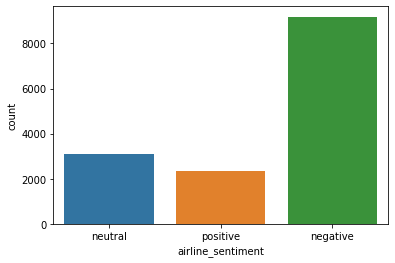

In [8]:
# Unique values of sentiment plot

ax = sns.countplot(x="airline_sentiment", data=df)

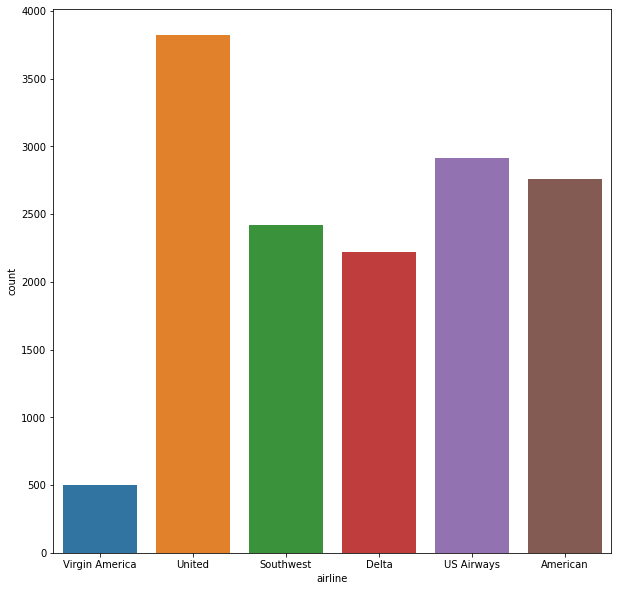

In [9]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

### Text cleaning

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['get','hour','http','co'])

def clean_text(text):
    text = re.sub("&[a-z]*;", " ",text)                                           # html tags such as &gt; 
    text = re.sub("[^a-zA-Z]", " ",text)                                          # keep only letters
    text = text.lower()                                                           # lower case                                              
      # Remove stop_word
    words = word_tokenize(text)
    new_text = ""
    for i,w in enumerate(words):
        if i == 0:                                                                  # first token is always airline name
            continue
        if w == 'flightled':
            w = 'flight'
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text
  #return ' '.join([word for word in text.split() if word.lower() not in stopwords.words('english')])                             

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from nltk import word_tokenize, pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatize_tag(text):
    lemma=[]
    for i,j in pos_tag(word_tokenize(text)) :
        p=j[0].lower()
        lm = ''
        if p in ['j','n','v']:
            if p == 'j':
                p = 'a'
            lm = wnl.lemmatize(i,p)
            
        else :
            lm = wnl.lemmatize(i)
        if len(lm) > 1:
            lemma.append(lm)
    return ' '.join(lemma)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
import nltk
nltk.download('omw-1.4')

i = 5

print("BEFORE:        "+df['text'][i])
print("CLEAN:         "+clean_text(df['text'][i]))
print("CLEAN & LEMM:  "+lemmatize_tag(clean_text(df['text'][i])))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


BEFORE:        @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
CLEAN:          seriously would pay flight seats playing really bad thing flying va
CLEAN & LEMM:  seriously would pay flight seat play really bad thing fly va


In [12]:
print(df.shape)

# removing neutral tweets
df = df[df['airline_sentiment']!='neutral']
print(df.shape)

# positive negative codification
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)

# removing neutral tweets
df['cleaned_tweet'] = df['text'].apply(clean_text)
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lemmatize_tag)

# remove rows with empty clean tweets
df = df[df['cleaned_tweet'].apply(len)>0]

print(df.shape)
df.head()


(14640, 15)
(11541, 15)


<ipython-input-12-a57e71de306b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)


(11529, 16)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercial experience tacky
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),seriously would pay flight seat play really ba...
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),yes nearly every time fly vx ear worm go away


In [13]:
df['airline_sentiment'].unique()

array([1, 0])

# Custom sentiment model

In [14]:
def check_scores(clf, X_train, X_test, y_train, y_test):

    model=clf.fit(X_train, y_train)
    predicted_class=model.predict(X_test)
    predicted_class_train=model.predict(X_train)
    test_probs = model.predict_proba(X_test)
    test_probs = test_probs[:, 1]

  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print()
  print("Train f1: ", f1_score(y_train, predicted_class_train))
  print("Test f1: ", f1_score(y_test, predicted_class))
  print()
  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  
  fig, ax1 = plt.subplots(1,1)

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  fpr, tpr, _ = roc_curve(y_test, test_probs)
  ax1.plot(fpr, tpr)
  ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                      param_grid = parameters,
                      cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model




### SVM

In [15]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)


In [16]:
# Tuning the hyperparameters
parameters ={
    "C":[0.1,0.3,1,3,10],
    "kernel":['linear']} 

svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Best parameters are: 
{'C': 3, 'kernel': 'linear'}


Train confusion matrix is: 
[[6838   32]
 [  95 1681]]

Test confusion matrix is: 
[[2214   85]
 [ 168  416]]

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2299
           1       0.83      0.71      0.77       584

    accuracy                           0.91      2883
   macro avg       0.88      0.84      0.86      2883
weighted avg       0.91      0.91      0.91      2883



Train f1:  0.9635998853539697
Test f1:  0.7668202764976959

Train accuracy score:  0.9853111265325005
Test accuracy score:  0.912244190079778

Train ROC-AUC score:  0.9952435923915183
Test ROC-AUC score:  0.9406215179917414


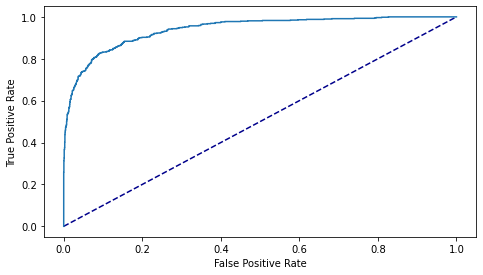

In [17]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)

### Using Multinomial Naive Bayes

Train confusion matrix is: 
[[6868    2]
 [1144  632]]

Test confusion matrix is: 
[[2296    3]
 [ 455  129]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2299
           1       0.98      0.22      0.36       584

    accuracy                           0.84      2883
   macro avg       0.91      0.61      0.63      2883
weighted avg       0.86      0.84      0.80      2883



Train f1:  0.5244813278008298
Test f1:  0.36033519553072624

Train accuracy score:  0.8674531575294934
Test accuracy score:  0.8411377037807839

Train ROC-AUC score:  0.964453427226353
Test ROC-AUC score:  0.9221884738450907


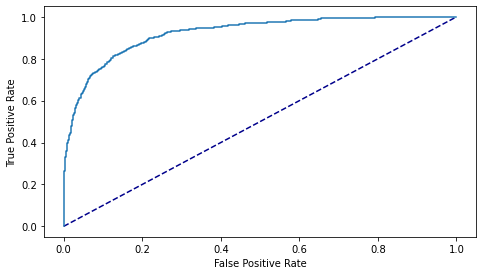

In [18]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)


### Adaboost

In [19]:
params = {'n_estimators': [100, 200, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}

ada_optimal_model = grid_search(AdaBoostClassifier(), params,x_train, y_train)

Best parameters are: 
{'learning_rate': 1.0, 'n_estimators': 200}


Train confusion matrix is: 
[[6709  161]
 [ 496 1280]]

Test confusion matrix is: 
[[2192  107]
 [ 232  352]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2299
           1       0.77      0.60      0.67       584

    accuracy                           0.88      2883
   macro avg       0.84      0.78      0.80      2883
weighted avg       0.88      0.88      0.88      2883



Train f1:  0.7957724588125583
Test f1:  0.6749760306807286

Train accuracy score:  0.9240111034004164
Test accuracy score:  0.882414151925078

Train ROC-AUC score:  0.9689236316010332
Test ROC-AUC score:  0.9011295858234969


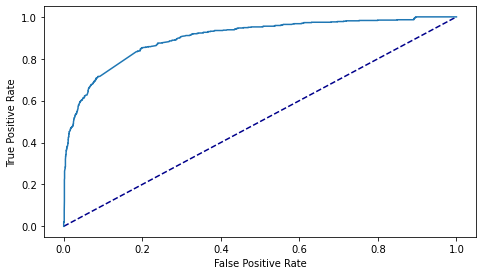

In [20]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc=check_scores(ada_optimal_model,x_train,x_test, y_train, y_test)


### Random Forest

Train confusion matrix is: 
[[6870    0]
 [ 293 1483]]

Test confusion matrix is: 
[[2179  120]
 [ 227  357]]

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2299
           1       0.75      0.61      0.67       584

    accuracy                           0.88      2883
   macro avg       0.83      0.78      0.80      2883
weighted avg       0.87      0.88      0.87      2883



Train f1:  0.910095121202823
Test f1:  0.6729500471253533

Train accuracy score:  0.9661114966458478
Test accuracy score:  0.8796392646548734

Train ROC-AUC score:  0.9967324311210773
Test ROC-AUC score:  0.8923195463185305


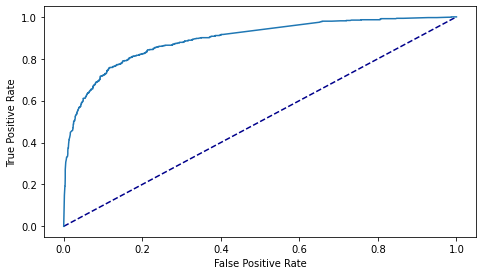

In [21]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0,max_features=0.3, max_depth=100).fit(x_train, y_train), x_train,x_test,y_train,y_test)


Final Results

In [23]:
data = [('SVM', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc),
('MultinomialNB',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc  ),
('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
('AdaBoost',ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc)]

Scores_ = pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train AUC', 'Test AUC'])
Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy,Train AUC,Test AUC
Model Name,,,,
SVM,0.985311,0.912244,0.995244,0.940622
MultinomialNB,0.867453,0.841138,0.964453,0.922188
Random Forest,0.966111,0.879639,0.996732,0.892320
AdaBoost,0.924011,0.882414,0.968924,0.901130


# Topic modeling
Why do people have a bad sentiment?

In [24]:
df_neg = df[df['airline_sentiment']==0]
df_neg.shape

(9169, 16)

In [25]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import TfidfModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import matutils, models
from gensim.corpora import Dictionary
import scipy.sparse

def prepare_corpus(doc_clean):
  # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
  #dictionary = corpora.Dictionary(doc_clean)
  # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
  #corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
  #tfidf = TfidfModel(corpus) ##ngram_range=(1,1),min_df=3
  #corpus_tfidf = tfidf[corpus]

    cv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=3)
    data_cv = cv.fit_transform(df_neg.cleaned_tweet)
    data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
    data.index = df_neg.index
    tdm = data.transpose()
    sparse_counts = scipy.sparse.csr_matrix(tdm)
    corpus = matutils.Sparse2Corpus(sparse_counts)

    #d = corpora.Dictionary()
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())
    #d.id2token = dict((v, k) for k, v in cv.vocabulary_.items())
    #d.id2token = id2word

    gensim_dict = Dictionary.from_corpus(corpus, id2word=id2word)

    return gensim_dict,corpus

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

print(df_neg['cleaned_tweet'].iloc[0])
dictionary, corpus = prepare_corpus(df_neg.cleaned_tweet.apply(word_tokenize))
print(corpus[0])
print(len(dictionary))


really aggressive blast obnoxious entertainment guest face little recourse
[(52, 0.4093206587489333), (249, 0.3988670588001145), (751, 0.3339233641376385), (818, 0.3388591853818621), (1014, 0.3988670588001145), (1321, 0.2959337381018054), (1828, 0.21910119420585708), (1845, 0.3903258457310167)]
2591


In [27]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LDA topic models
              c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate model
        model = LsiModel(corpus, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        c_v.append(coherencemodel.get_coherence())
    return model_list, c_v

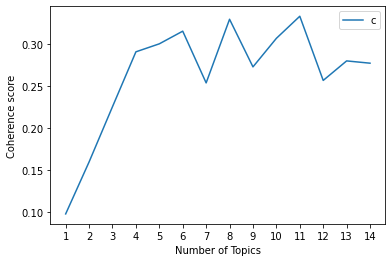

In [28]:
def plot_graph(doc_clean, start, stop, step):
    dictionary,corpus=prepare_corpus(doc_clean)
    model_list,c_v = compute_coherence_values(dictionary, corpus, doc_clean,
                                                            stop, start, step)
  

    # cv
    x = range(start, stop, step)
    fig = plt.plot(x, c_v, label = 'cv')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(('cv'), loc='best')
    plt.xticks(ticks = x)
    plt.show()
    plt.close()

    return model_list

model_list = plot_graph(df_neg.cleaned_tweet.apply(word_tokenize),1,15,1)

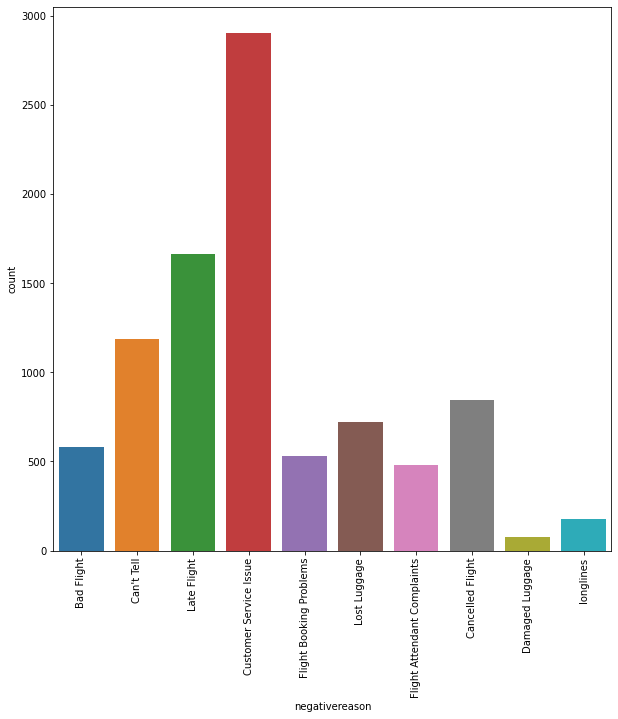

In [29]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="negativereason", data=df_neg)
ax.tick_params(axis='x', rotation=90)

In [30]:
ntopic = 6
model = model_list[ntopic-1]
model.show_topics()

[(0,
  '0.678*"flight" + 0.254*"cancel" + 0.161*"delay" + 0.157*"hold" + 0.138*"help" + 0.126*"time" + 0.124*"call" + 0.122*"wait" + 0.111*"service" + 0.109*"customer"'),
 (1,
  '0.509*"flight" + -0.365*"service" + -0.364*"customer" + 0.255*"cancel" + -0.228*"call" + -0.163*"wait" + -0.159*"hold" + -0.116*"bag" + -0.114*"time" + -0.112*"still"'),
 (2,
  '-0.463*"customer" + -0.459*"service" + 0.351*"hold" + 0.276*"call" + 0.190*"wait" + 0.173*"help" + -0.165*"bad" + 0.158*"minute" + -0.148*"flight" + -0.137*"ever"'),
 (3,
  '-0.373*"delay" + 0.357*"hold" + -0.287*"plane" + 0.229*"customer" + 0.225*"cancel" + 0.218*"service" + -0.218*"bag" + 0.217*"call" + 0.185*"help" + -0.184*"gate"'),
 (4,
  '0.453*"hold" + -0.343*"call" + 0.314*"wait" + 0.285*"minute" + 0.262*"delay" + 0.159*"min" + -0.147*"back" + -0.145*"bag" + 0.144*"service" + -0.130*"day"'),
 (5,
  '-0.354*"call" + 0.314*"hold" + 0.292*"bad" + 0.274*"airline" + 0.273*"fly" + -0.249*"wait" + 0.219*"help" + 0.208*"ever" + 0.184*"

In [31]:
list_guess = ['Flight Cancelled',   # 0
              'Flight Customer Service',   # 1
              'CS booking',   # 2
              'Flight Delay',   # 3
              'CS booking',   # 4
              'flight experience']   # 5]

In [32]:
lst = []
for topic in model.show_topics(formatted=False):
    tuples = topic[1]
    for tup in tuples:
        lst.append(tup[0])

counter=pd.DataFrame(lst).value_counts()
print(counter.head(10))
#plt.show()
print('\n')

hold        6
call        6
wait        5
service     5
help        4
customer    4
flight      3
delay       3
time        3
cancel      3
dtype: int64




### Find the most dominant topic in each document

In [33]:
corpus_transformed = model[corpus]
len(corpus_transformed)

9169

In [34]:
j=list(corpus_transformed)[0]
j[0][1]

0.013391203095677602

In [35]:
from pandas.core.common import not_none
topic_prediction=[]
for j in list(corpus_transformed):
    if len(j) > 0:
      main_topic=j[0][0]
      weigth=np.abs(j[0][1])
      for t,w in j:
          if np.abs(w) > weigth :
              main_topic=t
              weigth=np.abs(w)
    topic_prediction.append(main_topic)

In [36]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(df_neg.negativereason))

print(le.classes_)

enc_negativereason=le.transform(list(df_neg.negativereason))

['Bad Flight' "Can't Tell" 'Cancelled Flight' 'Customer Service Issue'
 'Damaged Luggage' 'Flight Attendant Complaints' 'Flight Booking Problems'
 'Late Flight' 'Lost Luggage' 'longlines']


In [37]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(enc_negativereason,topic_prediction,normalize='pred')
print(cm)

[[0.07307079 0.0174472  0.01746032 0.10185934 0.04562738 0.07161458
  0.         0.         0.         0.        ]
 [0.10175279 0.13131313 0.06031746 0.09135004 0.16825095 0.34895833
  0.         0.         0.         0.        ]
 [0.1768723  0.00550964 0.01111111 0.0113177  0.01806084 0.03125
  0.         0.         0.         0.        ]
 [0.22057819 0.61248852 0.7968254  0.08569119 0.43441065 0.26692708
  0.         0.         0.         0.        ]
 [0.00500797 0.01101928 0.0015873  0.01535974 0.01235741 0.00911458
  0.         0.         0.         0.        ]
 [0.05622581 0.04958678 0.02857143 0.07922393 0.02851711 0.04427083
  0.         0.         0.         0.        ]
 [0.08103802 0.01652893 0.03015873 0.00808407 0.07604563 0.05989583
  0.         0.         0.         0.        ]
 [0.2114728  0.04775023 0.03492063 0.39207761 0.07984791 0.11979167
  0.         0.         0.         0.        ]
 [0.05895743 0.07621671 0.01428571 0.17542441 0.11977186 0.0390625
  0.         0. 

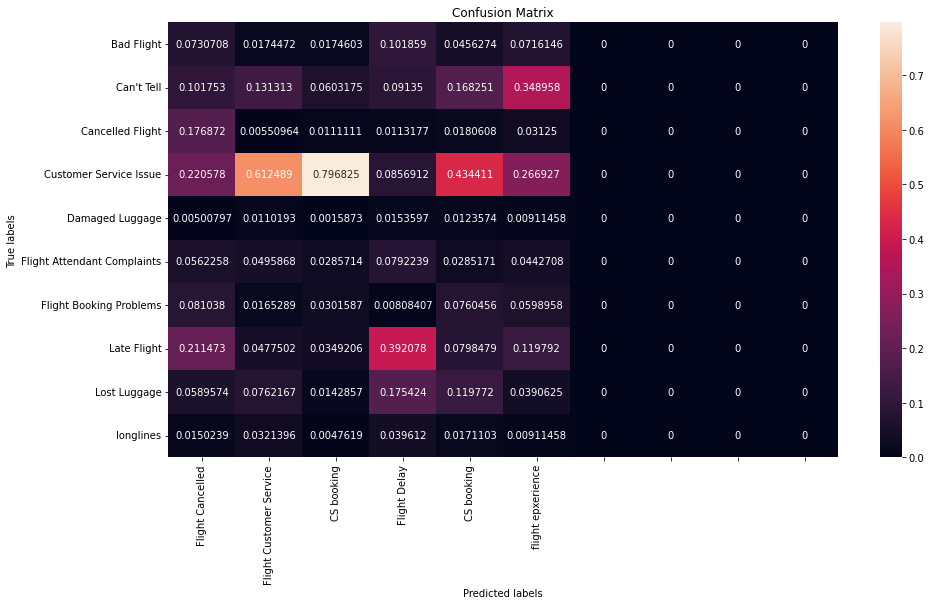

In [44]:
plt.figure(figsize = (15,8))

ax=sns.heatmap(cm, annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.yaxis.set_ticklabels(['Bad Flight', "Can't Tell", 'Cancelled Flight', 'Customer Service Issue',
 'Damaged Luggage', 'Flight Attendant Complaints', 'Flight Booking Problems',
 'Late Flight', 'Lost Luggage', 'longlines'])
ax.tick_params(axis='y', rotation=0)
ax.xaxis.set_ticklabels(list_guess+['','','',''])
ax.tick_params(axis='x', rotation=90)
plt.show()
plt.close()
#plt.set_xticklabels(ax.get_xticklabels(),rotation = 30)